# Temporal event detection using signal
This notebook explains how to use the new temporal event detection classes to detect audio event in real-time.

In [1]:
import numpy as np
import os
from scipy.io import wavfile 

from wavely.signal.features import features
from wavely.signal.features.acousticfeatures import spl
from wavely.signal.processing.event_detection import event_detection
from wavely.signal.units import helpers
import pandas as pd

## Compute features
The audio event detection class `event_detection.TemporalEventDetector` is based on the feature `rms` and the moving average of the `rms`, so that we will compute these features on the generate audio signal.

### Audio input signal 

The audio used here is a succession of differents events recorded with a Magneto. The file is available in the `data` DVC folder of this package. 

In [ ]:
cwd = os.getcwd()
signal_folder = os.path.abspath(os.path.join(cwd, os.pardir))
dvc_folder = os.path.join(signal_folder,'data/audio_sources/')
wave_file = dvc_folder + 'event_1.wav'

rate, _input =  wavfile.read(wave_file, mmap=False)

overlap_ratio = 0.0
rate = 96000
block_duration = 0.04
batch_size = 100
block_size = int(block_duration * rate)
n_fft = 4096

input_wav = _input

window_length = int(block_duration * rate)
blocks = helpers.split_signal(input_wav, rate, block_duration, overlap_ratio)
num_frames = blocks.shape[0]

# Features computation for signal
features_processor = features.FeaturesComputer(
    block_size=window_length, rate=rate, n_fft=n_fft, features=["rms"]
)
blocks_features = features_processor.compute(blocks, flatten=True)

timestamps = pd.to_timedelta([i * block_duration for i in range(num_frames)], unit="s")
computed_features = pd.DataFrame(blocks_features, index=timestamps)

## Input parameters of TemporalEventDetection
The paramter to use for Temporal Even Detection are available below.

In [3]:
block_duration = 0.04
min_length = 1
max_length = 60
min_level = 2
hysteresis = 0
detection_above_threshold= True
min_inter_event_time=1
integration_window=60

Creation of `TemporaEventDetector`, insertion of new feature in the temporal detector and pop all the event according to input signal.

In [4]:
temporal_detector = event_detection.TemporalEventDetector(block_duration,
                                                    min_length,
                                                    max_length,
                                                    min_level,
                                                    hysteresis,
                                                    detection_above_threshold,
                                                    min_inter_event_time,
                                                    integration_window)

events = []
val_test = 0
for index, feature in computed_features.iterrows():
    feature = dict(feature)
    feature["time"] = index
    temporal_detector.push(feature)
    event = temporal_detector.pop_event()
    if event is not None:
        events.append(event)
    val_test = val_test + 1
last_events = temporal_detector.flush()
events = events + last_events
valid_events = [(event[0].total_seconds(), event[1].total_seconds()) for event in events]

Compute and display the features ( `rms` and `mooving average rms`) used to implement the temporal event detection. Subplot the event detected by the algorithm and the related features. 

In [5]:
integration_frame = int(integration_window / block_duration)
max_frame = int(max_length / block_duration)
rms_buffer = np.zeros(max(integration_frame, max_frame))
rms_signal = np.zeros(len(computed_features["rms"]))
moving_rms_signal = np.zeros(len(computed_features["rms"]))
index = 0

for rms in computed_features["rms"]:
    rms_buffer = np.roll(rms_buffer, -1)
    rms_buffer[-1] = rms
    if index < integration_frame:
        threshold =  spl(
            rms_buffer[
                slice(len(rms_buffer) - (index+1),
                len(rms_buffer),
                )
            ].mean()
        )
    # threshold computation when RingBuffer is full
    else:
        threshold = spl(
           rms_buffer[
                slice(len(rms_buffer) - integration_frame,
                len(rms_buffer),
                )
            ].mean()
        )
    moving_rms_signal[index] = threshold
    rms_signal[index] = rms
    index = index+1

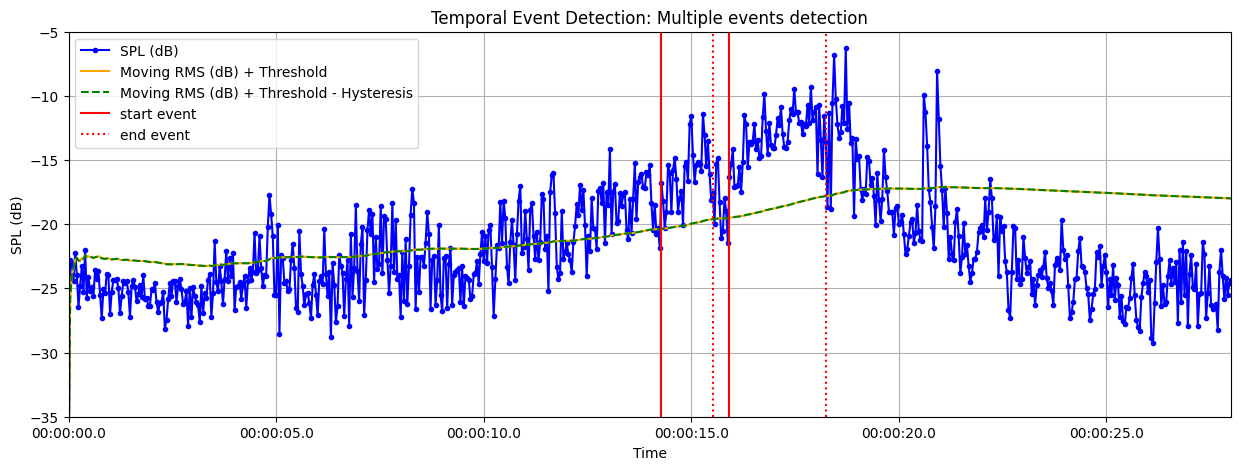

In [6]:
plot_features = pd.DataFrame([], index=timestamps)
plot_features["SPL (dB)"] = spl(rms_signal)
plot_features["Moving RMS (dB) + Threshold"] = moving_rms_signal + min_level
plot_features["Moving RMS (dB) + Threshold - Hysteresis"] = moving_rms_signal + min_level - hysteresis

x_start = pd.Timedelta(seconds=0) / pd.Timedelta(1,'ns')
x_end = pd.Timedelta(seconds=28) / pd.Timedelta(1,'ns')

ax = plot_features.plot(figsize=(15,5),
                        xlim = [x_start, x_end],
                        ylim=[-35, -5], 
                        grid=True, 
                        color={"SPL (dB)": "blue",
                               "Moving RMS (dB) + Threshold": "orange",
                               "Moving RMS (dB) + Threshold - Hysteresis": "green"},
                        style=[".-", "-", "--"],
                        title="Temporal Event Detection: Multiple events detection",
                        xlabel='Time',
                        ylabel='SPL (dB)')
is_first_event = True
for start, end in valid_events:
    start_pd = pd.Timedelta(seconds=start) / pd.Timedelta(1,'ns')
    end_pd = pd.Timedelta(seconds=end) / pd.Timedelta(1,'ns')
    if is_first_event:
       ax.axvline(start_pd, color="red", linestyle="solid", label="start event")
       ax.axvline(end_pd, color="red", linestyle="dotted", label="end event")
       is_first_event = False
    else:
       ax.axvline(start_pd, color="red", linestyle="solid")
       ax.axvline(end_pd, color="red", linestyle="dotted")

ax.xaxis.grid(True, which='both')
ax.legend()

In this example, the begining of a detected event is a straight red line and the end of detection is a dot red line. With the parameters selected at the begining of the notebook, we can detecte all the crossing line from the `SPL` curve and the `Moving RMS (dB) + Threshold` that can lead to a start of a new event and the crossing with the same curve minus `hysteresis` value to detect the end of the event. There is only one event saved which respect the `min_length` duration condition of 1sec. 